#### FILTER & NORMALIZE & ARRANGE Images

In [ ]:
import cv2
import numpy as np
import os
from sklearn.decomposition import PCA
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

##### FILTER
- Don't want images with multiple items
- Don't want images that don't have a clear single item

In [20]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
def is_valid_mask(image_path, max_fill_ratio=0.75):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
   
   # binary image
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    white_ratio = np.sum(binary == 255) / binary.size
    
    # get contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # filter out images with more than 1 contour (object)
    if len(contours) != 1:
        return False

    # filter out white blob images
    if white_ratio > max_fill_ratio:
        return False

    return True

note: not working for detecting 1 object when 3 vases are all touching, but does work when multiple vases are not touching. using an object detection model is much slower so I think this is fine for now

#### TEST

In [88]:
# public/data/initial_test/BRIA/1029mask.png --> valid
print(is_valid_mask("../public/data/initial_test/BRIA/1029mask.png"), "T")

# public/data/initial_test/BRIA/9511mask.png --> valid
print(is_valid_mask("../public/data/initial_test/BRIA/9511mask.png"), "T")

# public/data/initial_test/BRIA/9532mask.png --> invalid (multiple)
print(is_valid_mask("../public/data/initial_test/BRIA/9532mask.png"), "F")

# public/data/initial_test/BRIA/20106mask.png --> invalid (multiple)
print(is_valid_mask("../public/data/initial_test/BRIA/20106mask.png"), "F")

# public/data/initial_test/BRIA/20073mask.png --> invalid (blob)
print(is_valid_mask("../public/data/initial_test/BRIA/20073mask.png"), "F")


True T
True T
False F
True F
False F


In [ ]:
def extract_hu_moments(image_path, output_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

    # call this after validating with is_valid_mask so will always have 1 contour
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]  

    # crop image to bounding box
    x, y, w, h = cv2.boundingRect(cnt)
    cropped = binary[y:y+h, x:x+w]

    # resize and create new blank canvas for object
    scale = min(output_size[0] / h, output_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

    canvas = np.zeros(output_size, dtype=np.uint8)
    x_offset = (output_size[1] - new_w) // 2
    y_offset = (output_size[0] - new_h) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

    # get Hu Moments
    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments).flatten()
    # need to return log version for scaling/ normalizing numbers
    return -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

In [90]:
extract_hu_moments("../public/data/initial_test/BRIA/1029mask.png")

array([    0.44785,      1.0752,      2.5089,      2.7984,      5.4521,      3.3362,     -7.1761])

In [ ]:
# attempt to sort image shapes by on hu moments
def sort_images(folder_path):
    all_files = sorted(os.listdir(folder_path))
    image_paths = [os.path.join(folder_path, f) for f in all_files if f.lower().endswith((".png"))]
    
    valid_paths = []
    features = []

    for path in image_paths:
        if is_valid_mask(path):
            hu = extract_hu_moments(path)
            if hu is not None:
                valid_paths.append(path)
                features.append(hu)

    # print(features[0])

    pca = PCA(n_components=7)
    scores = pca.fit_transform(np.array(features))[:, 0]    
    sorted_indices = np.argsort(scores)
    sorted_paths = [valid_paths[i] for i in sorted_indices]

    return sorted_paths

In [139]:
folder_path = '../public/data/initial_test/BRIA'

all_files = sorted(os.listdir(folder_path))
image_paths = [os.path.join(folder_path, f) for f in all_files if f.lower().endswith((".png"))]

sorted_images = sort_images(folder_path)

print(len(sorted_images))
print(len(image_paths))

[    0.44785      1.0752      2.5089      2.7984      5.4521      3.3362     -7.1761]
260
280


In [140]:
def create_simple_contact_sheet(image_paths, thumb_size=(128, 128), columns=10, output_path="../public/data/initial_test/contact_sheet.jpg"):
    rows = (len(image_paths) + columns - 1) // columns
    sheet_width = columns * thumb_size[0]
    sheet_height = rows * thumb_size[1]

    contact_sheet = Image.new("RGB", (sheet_width, sheet_height), color="white")

    for i, path in enumerate(image_paths):
        img = Image.open(path).convert("RGB").resize(thumb_size)
        x = (i % columns) * thumb_size[0]
        y = (i // columns) * thumb_size[1]
        contact_sheet.paste(img, (x, y))

    contact_sheet.save(output_path)
    print(f"Saved: {output_path}")

In [141]:
create_simple_contact_sheet(image_paths=sorted_images,  output_path="../public/data/initial_test/sorted_contact_sheet.jpg")
create_simple_contact_sheet(image_paths=image_paths,  output_path="../public/data/initial_test/unsorted_contact_sheet.jpg")

Saved: ../public/data/initial_test/sorted_contact_sheet.jpg
Saved: ../public/data/initial_test/unsorted_contact_sheet.jpg


In [100]:
def cluster_image_shapes(folder_path, n_clusters=3):
    image_paths = [os.path.join(folder_path, f) for f in sorted(os.listdir(folder_path)) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    features = []
    valid_paths = []

    for path in image_paths:
        if is_valid_mask(path):
            hu = extract_hu_moments(path)
            if hu is not None:
                valid_paths.append(path)
                features.append(hu)

    features_np = np.array(features)

    # PCA to 2D for visualization
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features_np)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(reduced_features)

    return valid_paths, reduced_features, labels

In [110]:
paths, coords, labels = cluster_image_shapes(folder_path, n_clusters=6)

In [ ]:
def plot_shape_clusters(pca_coords, labels):
    n_clusters = len(set(labels))
    plt.figure(figsize=(8, 6))
    for i in range(n_clusters):
        pts = pca_coords[np.array(labels) == i]
        plt.scatter(pts[:, 0], pts[:, 1], alpha=0.7)
    plt.title("KMeans Clusters Vase Shapes Hu Moments ")
    plt.show()

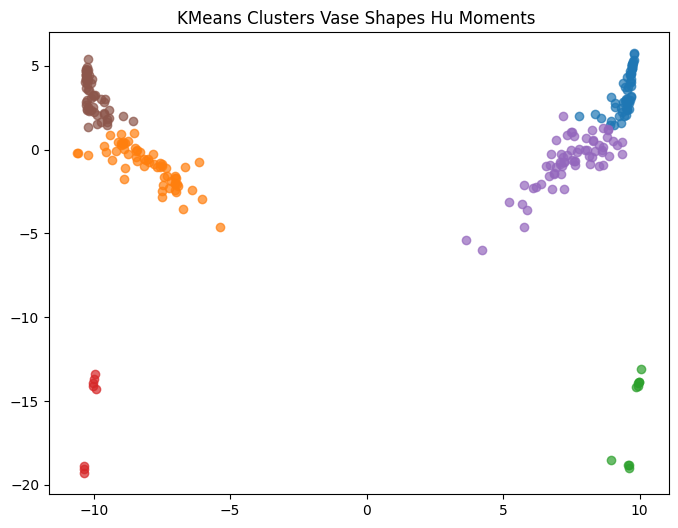

In [124]:
plot_shape_clusters(coords, labels)

In [127]:
def save_all_clusters_to_one_sheet(image_paths, labels, output_path="../public/data/initial_test/clustered_shapes_contact_sheet.jpg", thumb_size=(128, 128), images_per_row=10):
    # Group images by cluster
    clusters = {}
    for path, label in zip(image_paths, labels):
        clusters.setdefault(label, []).append(path)

    # Compute layout
    cluster_order = sorted(clusters.keys())
    max_rows_per_cluster = [((len(clusters[c]) + images_per_row - 1) // images_per_row) for c in cluster_order]
    total_rows = sum(max_rows_per_cluster)
    sheet_width = images_per_row * thumb_size[0]
    sheet_height = total_rows * thumb_size[1]

    # Create canvas
    contact_sheet = Image.new("RGB", (sheet_width, sheet_height), color="white")

    y_offset = 0
    for label in cluster_order:
        paths = clusters[label]
        for i, path in enumerate(paths):
            img = Image.open(path).convert("RGB").resize(thumb_size)
            x = (i % images_per_row) * thumb_size[0]
            y = y_offset + (i // images_per_row) * thumb_size[1]
            contact_sheet.paste(img, (x, y))
        y_offset += max_rows_per_cluster[label] * thumb_size[1]

    contact_sheet.save(output_path)
    print(f"Saved full contact sheet: {output_path}")

In [128]:
save_all_clusters_to_one_sheet(paths, labels)

Saved full contact sheet: ../public/data/initial_test/clustered_shapes_contact_sheet.jpg
